In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

# ---- Hybrid XPBD-GNN Surrogate ----
class XPBDGNNLayer(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels):
        super().__init__(aggr='mean')  # mean aggregation
        self.lin_node = nn.Linear(in_channels, out_channels)
        self.lin_edge = nn.Linear(edge_dim, out_channels)
        self.lin_msg = nn.Linear(out_channels, out_channels)
        self.act = nn.ReLU()

    def forward(self, x, edge_index, edge_attr):
        x_lin = self.lin_node(x)
        return self.propagate(edge_index, x=x_lin, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        e = self.lin_edge(edge_attr)
        msg = x_j + e
        return self.act(self.lin_msg(msg))

    def update(self, aggr_out):
        return aggr_out

class XPBDGNN(nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_dim, num_layers):
        super().__init__()
        self.input_lin = nn.Linear(node_feat_dim, hidden_dim)
        self.layers = nn.ModuleList([
            XPBDGNNLayer(hidden_dim, edge_feat_dim, hidden_dim)
            for _ in range(num_layers)
        ])
        self.output_lin_F = nn.Linear(hidden_dim, 4)    # deformation gradient
        self.output_lin_theta = nn.Linear(hidden_dim, 1)

    def forward(self, data: Data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        h = F.relu(self.input_lin(x))
        for layer in self.layers:
            h = layer(h, edge_index, edge_attr)
        F_pred = self.output_lin_F(h)
        theta_pred = self.output_lin_theta(h)
        return F_pred, theta_pred, h  # ← ADD this return


# ---- Physics-Informed Loss ----
def physics_informed_loss(F_pred, theta_pred, data, T, k_func, L_ref):
    row, col = data.edge_index
    k_vals = k_func(data.x)
    loss_therm = torch.mean((k_vals[row] * (T[row] - T[col]))**2)
    L_pred = torch.norm(data.pos[row] - data.pos[col], dim=-1)
    loss_length = F.mse_loss(L_pred, L_ref)
    return loss_therm + loss_length

# ---- Spectral-UNet 3D ----
class ConvBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm3d(out_ch)
        self.act = nn.LeakyReLU()
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class SpectralUNet(nn.Module):
    def __init__(self, in_bands, base_ch=32, num_classes=5):
        super().__init__()
        self.enc1 = ConvBlock3D(in_bands, base_ch)
        self.enc2 = ConvBlock3D(base_ch, base_ch*2)
        self.enc3 = ConvBlock3D(base_ch*2, base_ch*4)
        self.up2 = nn.ConvTranspose3d(base_ch*4, base_ch*2, 2, 2)
        self.dec2 = ConvBlock3D(base_ch*4, base_ch*2)
        self.up1 = nn.ConvTranspose3d(base_ch*2, base_ch, 2, 2)
        self.dec1 = ConvBlock3D(base_ch*2, base_ch)
        self.out_conv = nn.Conv3d(base_ch, num_classes, 1)

    def forward(self, x):  # Accepts just a tensor
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool3d(e1, 2))
        e3 = self.enc3(F.max_pool3d(e2, 2))
        d2 = self.dec2(torch.cat([self.up2(e3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)



# ---- Cross-Attention Controller ----
class CrossAttentionController(nn.Module):
    def __init__(self, gnn_dim, hsi_dim, attn_dim):
        super().__init__()
        self.W_q = nn.Linear(gnn_dim, attn_dim)
        self.W_k = nn.Linear(hsi_dim, attn_dim)
        self.W_v = nn.Linear(hsi_dim, attn_dim)
        self.norm = nn.LayerNorm(gnn_dim)
        self.policy = nn.Sequential(
            nn.Linear(gnn_dim, gnn_dim), nn.ReLU(),
            nn.Linear(gnn_dim, 3)
        )

    def forward(self, h_gnn, s_hsi):
        q, k, v = self.W_q(h_gnn), self.W_k(s_hsi), self.W_v(s_hsi)
        attn = F.softmax((q * k).sum(-1) / (k.size(-1)**0.5), dim=-1).unsqueeze(-1)
        h_attn = attn * v
        z = self.norm(h_gnn + h_attn)
        return self.policy(z)

# ---- Dummy Case ----
if __name__ == "__main__":
    # Dummy graph
    N, E = 10, 20
    node_feats = torch.randn(N, 8)
    edge_index = torch.randint(0, N, (2, E))
    edge_attr = torch.randn(E, 2)
    pos = torch.randn(N, 3)
    data = Data(x=node_feats, edge_index=edge_index, edge_attr=edge_attr, pos=pos)
    # Create models
    gnn = XPBDGNN(node_feat_dim=8, edge_feat_dim=2, hidden_dim=16, num_layers=2)
    unet = SpectralUNet(in_bands=50, base_ch=16, num_classes=5)
    #ctrl = CrossAttentionController(gnn_dim=16, hsi_dim=3, attn_dim=8)
    #ctrl = CrossAttentionController(gnn_dim=4, hsi_dim=3, attn_dim=8)
    ctrl = CrossAttentionController(gnn_dim=16, hsi_dim=3, attn_dim=16)

    # Forward passes
    #F_pred, theta_pred = gnn(data)
    F_pred, theta_pred, h = gnn(data)
    print("GNN outputs shapes:", F_pred.shape, theta_pred.shape)
    # Dummy HSI: batch 1, bands 50, spatial 32x32x
    hsi = torch.randn(1, 50, 32, 32, 8)
    seg_logits = unet(hsi)
    print("UNet output shape:", seg_logits.shape)
    # Dummy fusion
    #h_gnn = torch.mean(F_pred, dim=0)
    h_gnn = torch.mean(h, dim=0)  # h has shape [10, 16] → mean is [16]
    s_hsi = torch.tensor([0.8, 0.1, 0.1])  # good, void, fuzz
    actions = ctrl(h_gnn, s_hsi)
    print("Controller actions:", actions)


GNN outputs shapes: torch.Size([10, 4]) torch.Size([10, 1])
UNet output shape: torch.Size([1, 5, 32, 32, 8])
Controller actions: tensor([0.2537, 0.0628, 0.3216], grad_fn=<ViewBackward0>)


Controller actions: tensor([0.2537, 0.0628, 0.3216], grad_fn=<ViewBackward0>)


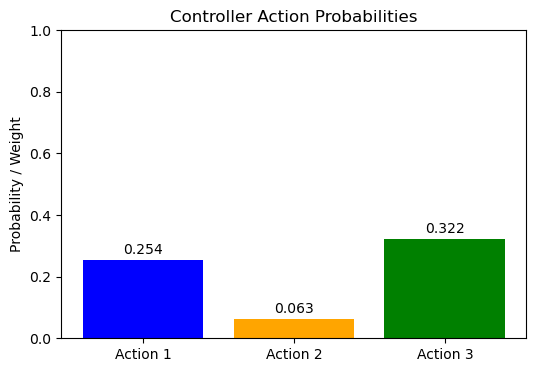

In [19]:
import matplotlib.pyplot as plt

# Ваш существующий код ...
# ...

if __name__ == "__main__":
    # ... (ваш код выше)
    print("Controller actions:", actions)

    # Визуализация действий контроллера
    actions_np = actions.detach().cpu().numpy()
    action_names = ['Action 1', 'Action 2', 'Action 3']

    plt.figure(figsize=(6,4))
    plt.bar(action_names, actions_np, color=['blue', 'orange', 'green'])
    plt.title('Controller Action Probabilities')
    plt.ylabel('Probability / Weight')
    plt.ylim(0, 1)
    for i, val in enumerate(actions_np):
        plt.text(i, val + 0.02, f"{val:.3f}", ha='center')
    plt.savefig("actions_PCM2.pdf")
    plt.show()


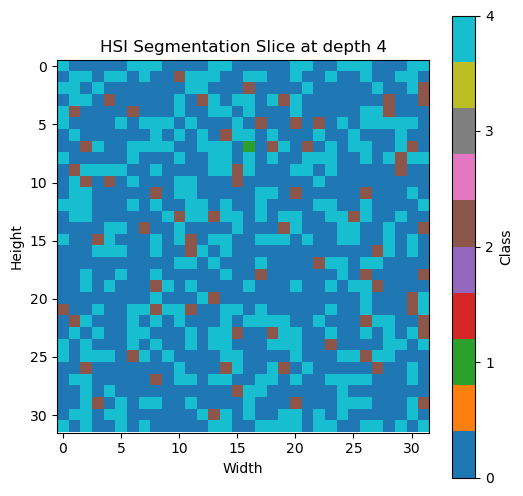

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# --- Визуализация HSI-сегментации ---
# Выбираем срез по 5-ому измерению (например, 4-й)
slice_idx = 4
seg_slice = seg_logits[0, :, :, :, slice_idx]  # shape [5, 32, 32]

# Получаем класс с максимальной вероятностью в каждом пикселе
seg_class_map = seg_slice.argmax(dim=0).cpu().numpy()  # shape [32,32]

plt.figure(figsize=(6,6))
plt.imshow(seg_class_map, cmap='tab10')  # colormap для категорий
plt.colorbar(ticks=range(5), label='Class')
plt.title(f'HSI Segmentation Slice at depth {slice_idx}')
plt.xlabel('Width')
plt.ylabel('Height')
plt.savefig("HSI_PCM2.pdf")
plt.show()




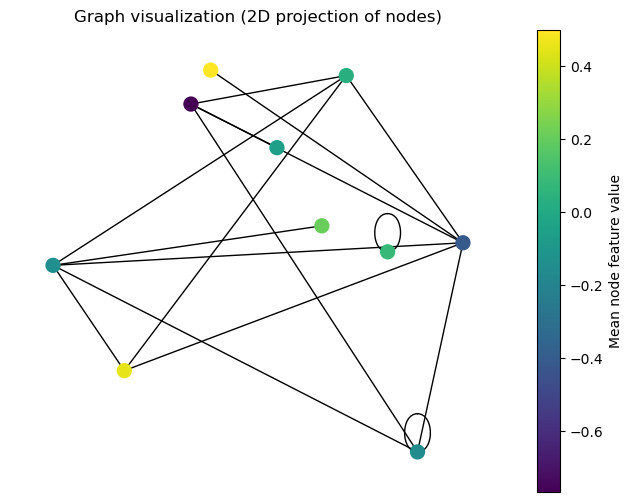

In [17]:
# --- Визуализация графа ---
G = nx.Graph()

# Добавляем узлы с позициями из data.pos
pos_np = data.pos.cpu().numpy()
for i, coord in enumerate(pos_np):
    G.add_node(i, pos=coord)

# Добавляем рёбра из edge_index
edge_index_np = data.edge_index.cpu().numpy()
edges = list(zip(edge_index_np[0], edge_index_np[1]))
G.add_edges_from(edges)

# Цвет узлов - например, возьмем среднее значение фич из data.x
node_feats_mean = data.x.mean(dim=1).cpu().numpy()

plt.figure(figsize=(8,6))
nx_pos = {i: pos_np[i, :2] for i in range(len(pos_np))}  # берем первые 2 координаты для 2D

nodes = nx.draw_networkx_nodes(G, pos=nx_pos, node_size=100,
                               node_color=node_feats_mean, cmap='viridis')
edges = nx.draw_networkx_edges(G, pos=nx_pos)
plt.colorbar(nodes, label='Mean node feature value')
plt.title('Graph visualization (2D projection of nodes)')
plt.axis('off')
plt.savefig("Graph_PCM2.pdf")
plt.show()
